#ШАГ 1. Создание таблиц

##Создание таблицы customer

``` sql
create table customer (
	customer_id int primary key,
	first_name varchar(20) not null,
	last_name varchar(30),
	gender varchar(10) not null,
	DOB date,
	job_title varchar(50),
	job_industry_category varchar(50),
	wealth_segment varchar (30),
	deceased_indicator varchar(1) not null,
	owns_car varchar(3) not null,
	address varchar(50) not null,
	postcode int not null,
	state varchar(30) not null,
	country varchar(30) not null,
	property_valuation int not null
)
```
##Создание таблицы product
*В связи с неуникальностью product_id был сделан новый уникальный ключ new_product_id*
```sql
create table product (
    new_product_id int primary key,
	product_id int,
	brand varchar(20),
	product_line varchar(20),
	product_class varchar(6),
	product_size varchar(6),
	list_price decimal(6, 2) not null,
	standard_cost decimal(6, 2)
)
```
##Создание таблицы orders


```sql
create table orders (
	order_id int primary key,
	customer_id int not null,
	order_date date not null,
	online_order boolean,
	order_status varchar(9) not null
)

```

##Создание таблицы order_items

```sql
create table order_items (
	order_item_id int primary key,
	order_id int not null,
    new_product_id int not null,
	product_id int not null,
	quantity decimal(3, 1) not null,
	item_list_price_at_sale decimal(6, 2) not null,
	item_standard_cost_at_sale decimal(6, 2)
)
```








# ШАГ 2. Выполнение запросов

1. **Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества.**



```sql
select
	job_industry_category,
	count(*) as customer_count
from customer
group by job_industry_category
order by customer_count desc
```
## Результат запроса

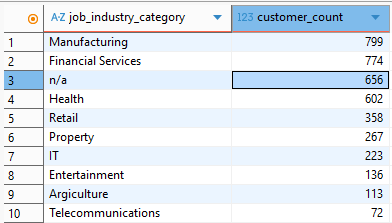

2. **Найти общую сумму дохода (list_price*quantity) по всем подтвержденным заказам за каждый месяц по сферам деятельности клиентов. Отсортировать результат по году, месяцу и сфере деятельности.**



```sql
select
	date_trunc('month', o.order_date) as month,
	c.job_industry_category,
	sum(oi.item_list_price_at_sale * oi.quantity) as total_revenue
from orders o
join order_items oi on o.order_id = oi.order_id
join customer c on o.customer_id = c.customer_id
where o.order_status = 'Approved'
group by month, c.job_industry_category
order by month, c.job_industry_category
```
## Результат запроса
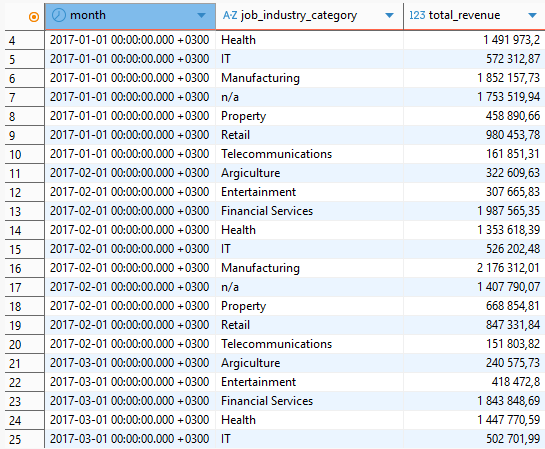

3. **Вывести количество уникальных онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT. Включить бренды, у которых нет онлайн-заказов от IT-клиентов, — для них должно быть указано количество 0.**



```sql
select
  p.brand,
  count(distinct o.order_id) filter (
    where o.online_order = 'True'
    and c.job_industry_category = 'IT'
  ) as online_orders_it
from product p
left join order_items oi on p.product_id = oi.product_id
left join orders o on oi.order_id = o.order_id and o.order_status = 'Approved'
left join customer c on o.customer_id = c.customer_id
group by p.brand
order by p.brand
```
## Результат запроса
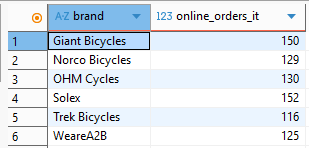


4. **Найти по всем клиентам: сумму всех заказов (общего дохода), максимум, минимум и количество заказов, а также среднюю сумму заказа по каждому клиенту. Отсортировать результат по убыванию суммы всех заказов и количества заказов. Выполнить двумя способами: используя только GROUP BY и используя только оконные функции. Сравнить результат.**


**1 способ используя только GROUP BY**

```sql
with order_totals as (
  select
    o.order_id,
    o.customer_id,
    sum(oi.item_list_price_at_sale * oi.quantity) as order_total
  from orders o
  join order_items oi on o.order_id = oi.order_id
  where o.order_status = 'Approved'
  group by o.order_id, o.customer_id
)
select
  c.customer_id,
  c.first_name,
  c.last_name,
  coalesce(count(ot.order_id), 0) as orders_count,
  coalesce(sum(ot.order_total), 0) as total_revenue,
  coalesce(max(ot.order_total), 0) as max_order,
  coalesce(min(ot.order_total), 0) as min_order,
  case when count(ot.order_id) = 0 then 0
       else sum(ot.order_total) / count(ot.order_id) end as avg_order
from customer c
left join order_totals ot on c.customer_id = ot.customer_id
group by c.customer_id, c.first_name, c.last_name
order by total_revenue desc, orders_count desc

```
## Результаты запроса
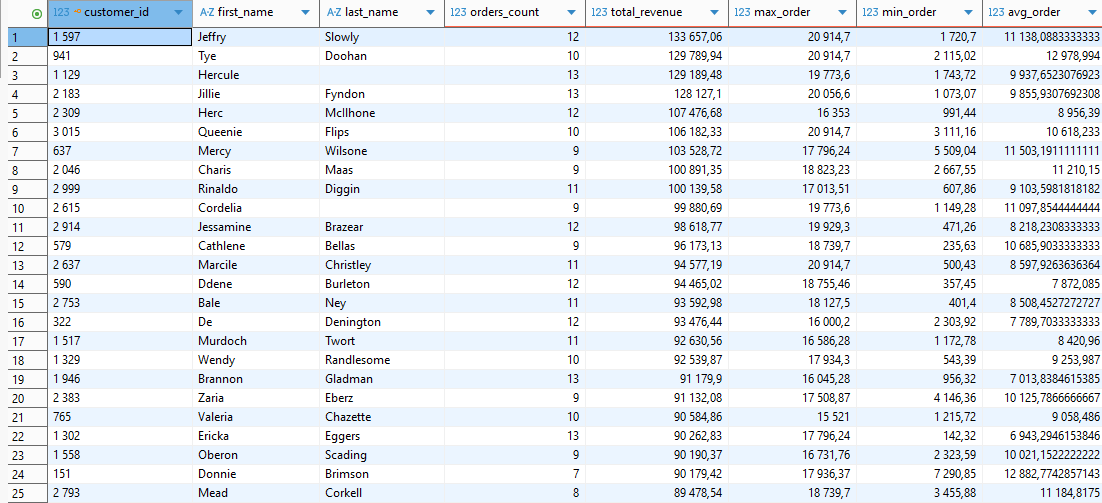

**2 способ используя только оконные функции**

```sql
with order_totals as (
  select
    o.order_id,
    o.customer_id,
    sum(oi.item_list_price_at_sale * oi.quantity) as order_total
  from orders o
  join order_items oi on o.order_id = oi.order_id
  where o.order_status = 'Approved'
  group by o.order_id, o.customer_id
)
select distinct
  c.customer_id,
  c.first_name,
  c.last_name,
  coalesce(sum(ot.order_total) over (partition by c.customer_id), 0) as total_revenue,
  coalesce(max(ot.order_total) over (partition by c.customer_id), 0) as max_order,
  coalesce(min(ot.order_total) over (partition by c.customer_id), 0) as min_order,
  coalesce(count(ot.order_id) over (partition by c.customer_id), 0) as orders_count,
  coalesce(avg(ot.order_total) over (partition by c.customer_id), 0) as avg_order
from customer c
left join order_totals ot on c.customer_id = ot.customer_id
order by total_revenue desc, orders_count desc;

```
## Результаты запроса
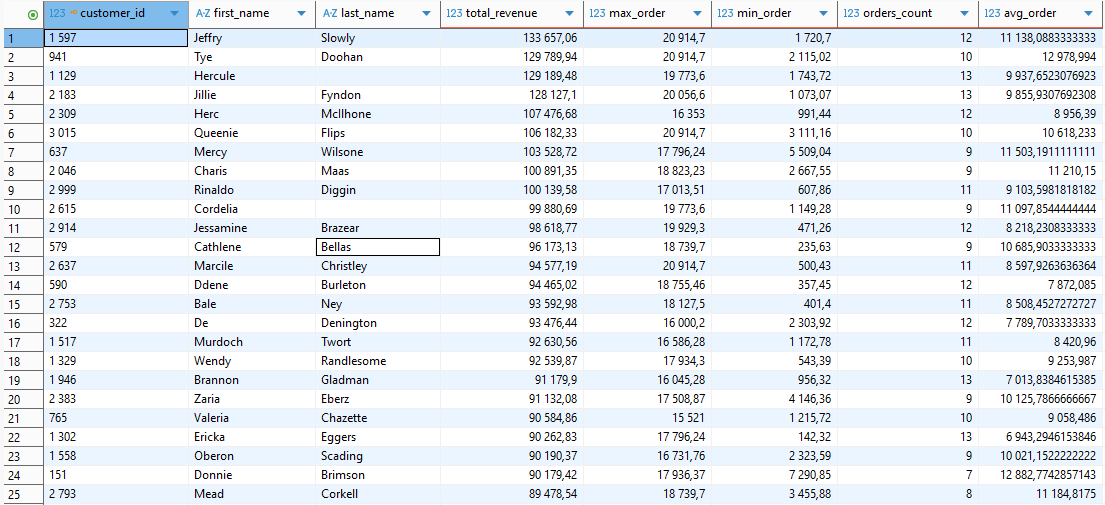

5. **Найти имена и фамилии клиентов с топ-3 минимальной и топ-3 максимальной суммой транзакций за весь период (учесть клиентов, у которых нет заказов, приняв их сумму транзакций за 0).**



```sql
with customer_total as (
  select
    c.customer_id,
    c.first_name,
    c.last_name,
    coalesce(sum(oi.item_list_price_at_sale * oi.quantity), 0) as total_revenue
  from customer c
  left join orders o on c.customer_id = o.customer_id and o.order_status = 'approved'
  left join order_items oi on o.order_id = oi.order_id
  group by c.customer_id, c.first_name, c.last_name
),
ranked as (
  select
    *,
    dense_rank() over (order by total_revenue asc) as dr_min,
    dense_rank() over (order by total_revenue desc) as dr_max
  from customer_total
)
select
  customer_id,
  first_name,
  last_name,
  total_revenue,
  case when dr_min <= 3 then 'top3_min' end as which_min,
  case when dr_max <= 3 then 'top3_max' end as which_max
from ranked
where dr_min <= 3 or dr_max <= 3
order by total_revenue
```
## Результат запроса
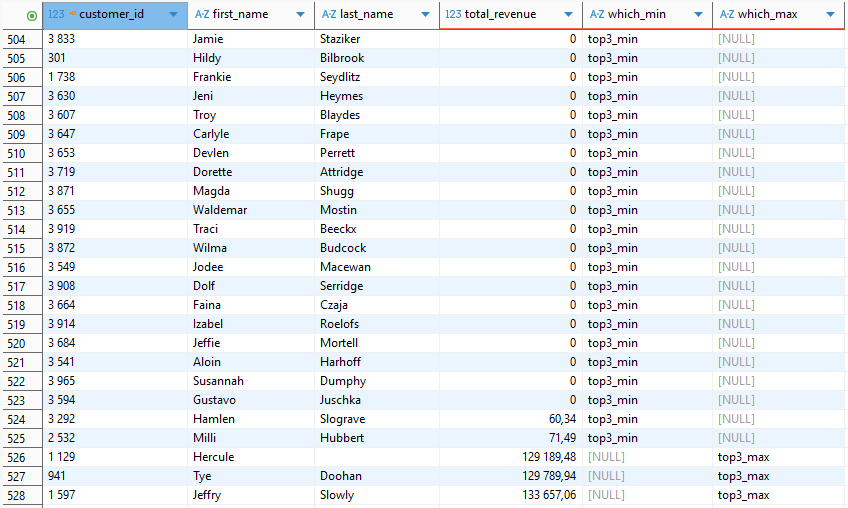

6. **Вывести только вторые транзакции клиентов (если они есть) с помощью оконных функций. Если у клиента меньше двух транзакций, он не должен попасть в результат.**



```sql
with ranked_orders as (
  select
    o.*,
    row_number() over (
      partition by o.customer_id
      order by o.order_date, o.order_id
    ) as rn
  from orders o
  where o.order_status = 'Approved'
)
select
  order_id,
  customer_id,
  order_date,
  order_status
from ranked_orders
where rn = 2
```
## Результат запроса
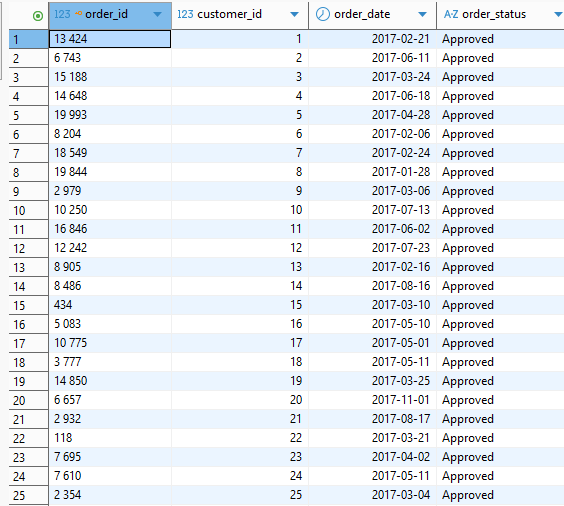



7. **Вывести имена, фамилии и профессии клиентов, а также длительность максимального интервала (в днях) между двумя последовательными заказами. Исключить клиентов, у которых только один или меньше заказов.**



```sql
with customer_orders as (
    select
        c.customer_id,
        c.first_name,
        c.last_name,
        c.job_title,
        o.order_id,
        o.order_date,
        lead(o.order_date) over (
            partition by c.customer_id
            order by o.order_date
        ) as next_order_date
    from customer c
    join orders o on c.customer_id = o.customer_id
    where o.order_status = 'Approved'
),
intervals as (
    select
        customer_id,
        first_name,
        last_name,
        job_title,
        (next_order_date - order_date) as diff_days
    from customer_orders
    where next_order_date is not null
)
select
    customer_id,
    first_name,
    last_name,
    job_title,
    max(diff_days) as max_interval_days
from intervals
group by customer_id, first_name, last_name, job_title
order by max_interval_days desc
```
## Результат запроса
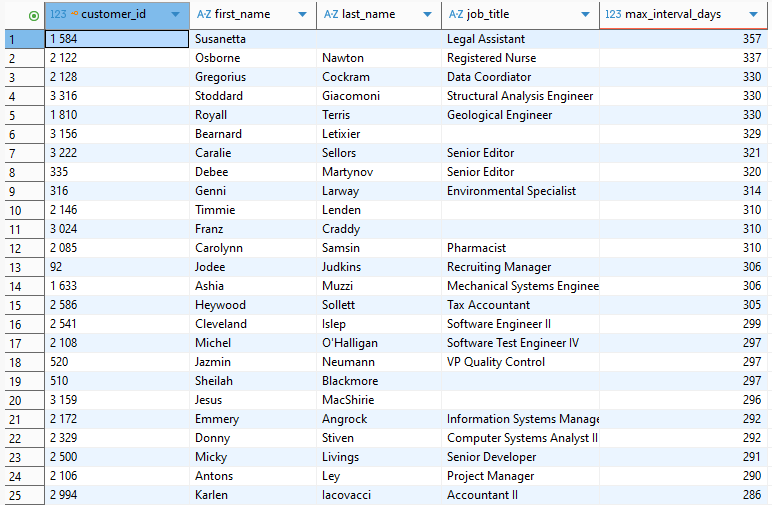


8. **Найти топ-5 клиентов (по общему доходу) в каждом сегменте благосостояния (wealth_segment). Вывести имя, фамилию, сегмент и общий доход. Если в сегменте менее 5 клиентов, вывести всех.**



```sql
with customer_total as (
  select
    c.customer_id,
    c.first_name,
    c.last_name,
    c.wealth_segment,
    coalesce(sum(oi.item_list_price_at_sale * oi.quantity), 0) as total_revenue
  from customer c
  left join orders o on c.customer_id = o.customer_id and o.order_status = 'Approved'
  left join order_items oi on o.order_id = oi.order_id
  group by c.customer_id, c.first_name, c.last_name, c.wealth_segment
),
ranked as (
  select
    *,
    row_number() over (partition by wealth_segment order by total_revenue desc) as rn
  from customer_total
)
select
  customer_id,
  first_name,
  last_name,
  wealth_segment,
  total_revenue
from ranked
where rn <= 5
order by wealth_segment, total_revenue desc
```
## Результат запроса
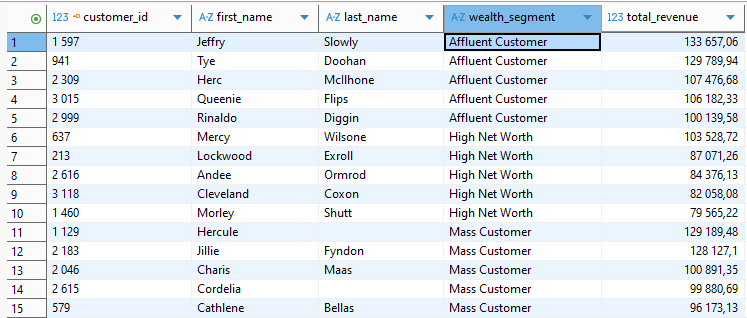